## Ensemble Probability with Python ##
**Tyler Wixtrom**<br>
*Texas Tech University*<br>
tyler.wixtrom@ttu.edu<br>

Unidata Users Workshop<br>
*June 25-28, 2018<br>
Boulder, CO*

In this example, we will compute and plot ensemble probability for simulated reflectivity greater than 25 dBz.


In [26]:
import numpy as np
from netCDF4 import Dataset, num2date
import operator
from pint import UnitRegistry
units = UnitRegistry()

We will start by reading in the simulated reflectivity data from each ensemble member with the netCDF4-python package and storing the data in a dictionary.

In [14]:
refl = {}
for i in range(1, 21):
    data = Dataset('../2015020112/wrfprst_d01_2015020112_mem'+str(i)+'.nc')
    refl['mem'+str(i)] = data.variables['DBZ'][:].data

In [15]:
lat = data.variables['lat'][0, :]
lon = data.variables['lon'][0, :]
vtimes = num2date(data.variables['valid_time'][:], data.variables['valid_time'].units)

### Ensemble Probability ###
Ensemble probability is a relatively simple calculation and can be acomplished quite easily in python. The probability is simply defined as the number of members meeting a pre-defined criteria (for this example simulated reflectivity greater than 25 dBz) divided by the total number of members. 

### Operator Module ###
The `operator` module is part of the built-in python libraries and is a function representation of the more commonly used comparison operator syntax. 
<br>For example:<br>
```python
data = np.linspace(0, 100, 50)
subset = data[data >= 50.]
```
is equivalent to:<br>
```python
data = np.linspace(0, 100, 50)
subset = data[operator.ge(data, 50.)]
```
We can use this module to create a function that will output ensemble probability based on an input threshold, operator, and ensemble members.

In [33]:
def ens_prob(thresh, operator, *args):
    """Computes the ensemble probability
    thresh: Input threshold for probability calculations
    operator: Operator module function
    args: ensemble member arrays
    """
    thresh_arg_data = []
    for arg in args:
        data = np.zeros_like(arg)
        data[operator(arg, thresh)] = 1.
        thresh_arg_data.append(data)
    thresh_data = np.stack(thresh_arg_data, axis=0)
    return np.mean(thresh_data, axis=0)

In [34]:
points = ens_prob(25., operator.gt, *[refl[key] for key in refl.keys()])

We will plot the point probabilities with Matplotlib and Cartopy as in previous examples

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up our projection
plotcrs = ccrs.AlbersEqualArea(central_longitude=-100.0, central_latitude=45.0)

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lakes',
    scale='50m',
    facecolor='none')

In [ ]:
# Choose a time to plot
time = 2

# Set up the figure and add a map background
fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(111, projection=plotcrs)
ax.set_extent((-123, -74, 25, 51), ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the surface
contours = np.arange(0.1, 1.1, 0.1)
cf = ax.contourf(lon, lat, points[time,], contours, transform=ccrs.PlateCarree(), cmap=plt.cm.viridis)
plt.colorbar(cf, orientation='horizontal', shrink=0.5, pad=0.05)

# Make some titles
plt.title('Point Probability of Reflectivity Greater Than 25 dBz', loc='left')
plt.title('VALID: {0:%Y-%m-%d %H:%M:%S}'.format(vtimes[time]), loc='right')
plt.show()

### Ensemble Probability of Nearby Occurence ###

The above ensemble probability calculation is considered to be defined for a single point. However, this calculation does not account for spatial variability or more generally the chance of occurence nearby to any single point. Therefore, the Neighborhood Mean Ensemble Probability is often used for predicting phenomena such as convection where forecasters are more interested in the chance of nearby occurence rather than the probability of occurence at any single point.

#### Neighborhood Ensemble Probability (NEP) ####

The most common approach to calculating the probability of occurence within a distance of a single point is reffered to as the Neighborhood Ensemble Probability (NEP, Schwartz and Sobash, 2017). Is this approach, the probability at each point is first calculated, and the the mean probability of all points within a specified radius is calculated, which is defined as NEP, or the probability of occurence within the radius of any given point.

### Calculating NEP ###

We will start by first using cartopy to transform the coordiante latitude and longitude points to x and y in meters by using and equal area projection.

In [27]:
crs = ccrs.AlbersEqualArea(central_longitude=-100.0, central_latitude=45.0)
tlatlons = crs.transform_points(ccrs.PlateCarree(), lon, lat)
tlons = tlatlons[:, :, 0] * units('meter')
tlats = tlatlons[:, :, 1] * units('meter')

While the transformation from ensemble point probabilities to NEP is relatively simple, finding all points within the specified radius is rather slow in an interpreted language such as python. To speed this up, we will utilize the [Numba](https://numba.pydata.org) package which will convert the written python code into compiled C code, greatly reducing the runtime.

### Numba ###
The [Numba](https://numba.pydata.org) package is designed to take written python code and convert it to C code that is compiled the first time the function is called, resulting in much faster execution than would be possible in the native interpreted python code. To maximize the speed of the resulting code, functions should be written without the "normal" methods of numpy vectorization and library function calls. This is best accomplished by adding the decorator `@njit` to the beginning of the function. This will attempt to convert all code into C without allowing any python code to execute.

In [38]:
from numba import njit

@njit
def distance_mask(x, y, x1, y1, r, xshape, yshape):
    """Find all points within the specified radius
    
    x: x coordinate array
    y: y coordinate array
    x1: center point x-coordinate
    y1: center point y-coordinate
    """
    num = 0
    xi = []
    yi = []
    for i in range(xshape):
        for j in range(yshape):
            # calculate distance to point on grid
            d = ((x[i, j] - x1)**2 + (y[i, j] - y1)**2)**0.5
            # put x and y indices into list if point is 
            # within radius of center point
            if d <= r:
                xi.append(i)
                yi.append(j)
                # keep track of total number of points
                num += 1.
    return xi, yi, num


@units.wraps('=A', ('=A', '=B', '=B', '=B'))
@njit
def neighborhood_prob(points, r, x, y):
    """Computes ensemble neighborhood probability
    
    points: array of point ensemble probabilities
    r: radius for neighborhood calculation
    x: x coordinate array
    y: y coordinate array
    """
    neighbor_probs = np.full_like(points, np.nan)
    tshape, xshape, yshape = points.shape
    
    for i in range(xshape):
        for j in range(yshape):
            # get the distance to every point on the grid
            xi, yi, num = distance_mask(x, y, x[i, j], y[i, j], r, xshape, yshape)
            
            # Take mean of points within specified radius at each timestep
            for k in range(tshape):
                point_sum = 0
                for a in range(len(xi)):
                    # Sum all of the points within radius of center point
                    point_sum += points[k, xi[a], yi[a]]
                # take average for neighborhood probability
                neighbor_probs[k, i, j] = point_sum / num
   
    return neighbor_probs

In [39]:
nprobs = neighborhood_prob(points[:3], 40 * units('km'), tlons, tlats)

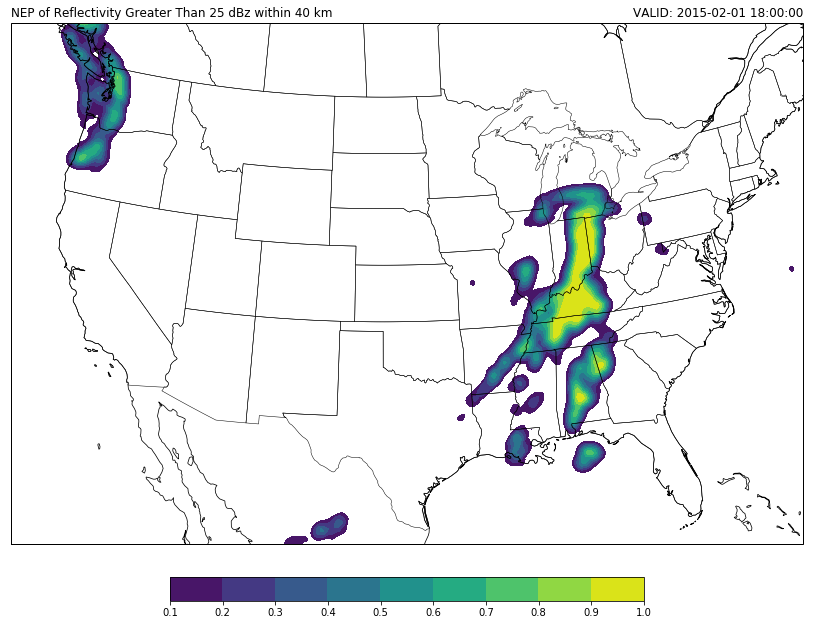

In [41]:
# Choose a time to plot
time = 2

fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(111, projection=plotcrs)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent((-123, -74, 25, 51), ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the surface
contours = np.arange(0.1, 1.1, 0.1)
cf = ax.contourf(lon, lat, nprobs[time, ],
                 contours, transform=ccrs.PlateCarree(), cmap=plt.cm.viridis)
plt.colorbar(cf, orientation='horizontal', shrink=0.5, pad=0.05)
# Make some titles
plt.title('NEP of Reflectivity Greater Than 25 dBz within 40 km', loc='left')
plt.title('VALID: {0:%Y-%m-%d %H:%M:%S}'.format(vtimes[time]), loc='right')
plt.show()

### Your Turn! ###

Try creating a plot of either ensemble probabilities or NMEP for updraft helicity (UH) greater than 25 m$^2$s$^{-2}$

In [ ]:
uh = {}
for i in range(1, 21):


In [40]:
# %load solutions/probability_solution.py